In [5]:
import os
import glob
import pandas as pd
#from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

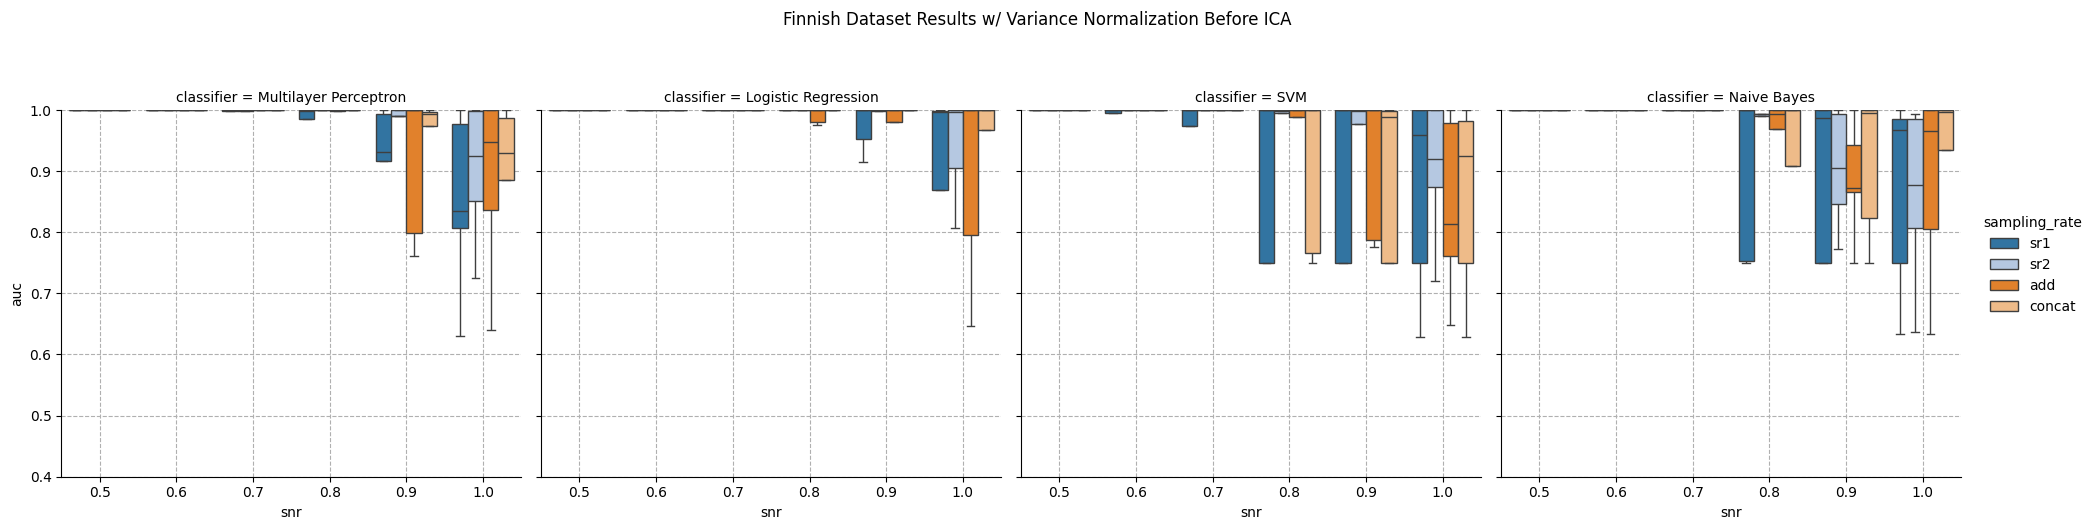

In [8]:
pkl_dir = '/data/users2/jwardell1/undersampling-project/OULU/pkl-files/'

# Read and concatenate sr1 data
joined_files = os.path.join(pkl_dir, 'sr1_*.pkl')
joined_list = glob.glob(joined_files)
sr1 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr1') for file in joined_list), ignore_index=True)

# Read and concatenate sr2 data
joined_files = os.path.join(pkl_dir, 'sr2_*.pkl')
joined_list = glob.glob(joined_files)
sr2 = pd.concat((pd.read_pickle(file).assign(sampling_rate='sr2') for file in joined_list), ignore_index=True)

# Read and concatenate concat data
joined_files = os.path.join(pkl_dir, 'concat_*.pkl')
joined_list = glob.glob(joined_files)
concat = pd.concat((pd.read_pickle(file).assign(sampling_rate='concat') for file in joined_list), ignore_index=True)

# Read and concatenate add data
joined_files = os.path.join(pkl_dir, 'add_*.pkl')
joined_list = glob.glob(joined_files)
add = pd.concat((pd.read_pickle(file).assign(sampling_rate='add') for file in joined_list), ignore_index=True)

# Concatenate all dataframes
all_data = pd.concat([sr1, sr2, concat, add], ignore_index=True)



# Function to split each row into multiple rows based on cross-validation index
def split_row(row):
    new_rows = []
    for cv_ix, auc in enumerate(row['test_scores']):
        new_row = row.copy()
        new_row['auc'] = auc
        new_row['cv_ix'] = cv_ix
        new_rows.append(new_row)
    return pd.DataFrame(new_rows)

# Apply the split_row function to each row of the dataframe and concatenate the results
result_df = pd.concat(all_data.apply(split_row, axis=1).tolist(), ignore_index=True)



# Drop the original 'test_scores' column as it's no longer needed
result_df.drop('test_scores', axis=1, inplace=True)



grouped_classifiers = result_df.groupby('classifier')


classifier_dfs = {}
for classifier, group_df in grouped_classifiers:
    classifier_dfs[classifier] = group_df.copy()

mlp_df = classifier_dfs['Multilayer Perceptron']
lr_df = classifier_dfs['Logistic Regression']
svm_df = classifier_dfs['SVM']
nb_df = classifier_dfs['Naive Bayes']


dfs = [mlp_df, lr_df, svm_df, nb_df]
classifiers = ['Multilayer Perceptron', 'Logistic Regression', 'SVM', 'Naive Bayes']
sampling_rates = ['sr1', 'sr2', 'add', 'concat']
#sampling_rates = [ 'sr2', 'add', 'concat']
hue_order = sampling_rates
palette = { item: plt.cm.tab20(i) for i, item in enumerate(sampling_rates)}

# Combine all dataframes into one dataframe for plotting
combined_df = pd.concat(dfs)
#snr_levels = [0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.0 , 1.1 , 1.2 , 1.3 , 1.4 , 1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2.0]
snr_levels = [0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.0]



yticks_start = 0.4
yticks_step = 0.1

ax = sns.catplot(
    x="snr", 
    order=snr_levels,
    y="auc",
    hue="sampling_rate",
    hue_order=hue_order,
    col="classifier",
    data=combined_df,
    kind="box",
    palette=palette,
    showfliers=False, 
)


ax.set(ylim=(yticks_start, 1), yticks=[i for i in np.arange(yticks_start, 1 + yticks_step, yticks_step)])

ax.fig.suptitle("Finnish Dataset Results w/ Variance Normalization Before ICA", y=1.05)

plt.subplots_adjust(top=0.85)
for axes in ax.axes.flat:
    axes.grid(True, which='both', axis='both', linestyle='--')

AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

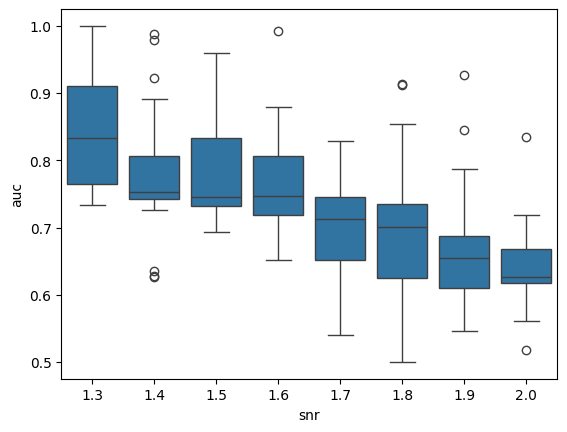

In [58]:
x="snr"
y="auc"
snr_levels = [1.3 , 1.4 , 1.5 , 1.6 , 1.7 , 1.8 , 1.9 , 2.0]
order = snr_levels

ax = sns.boxplot(data=mlp_df, x=x, y=y, order=order)


pairs = [(snr_levels[i], snr_levels[i+1]) for i in range(len(snr_levels)-1)]


annotator = Annotator(ax, pairs, data=mlp_df, x=x, y=y, order=order)
annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
annotator.apply_and_annotate()

